In [1]:
import pickle
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from modeling_gemma import KVCache
from processing_paligemma import PaliGemmaProcessor, LabelProcessor
from utils import move_inputs_to_device
from prepare_data import ImageInstructionOutputDataset, update_tokenizer, update_embeddings, prepare_dataset
from utils import *
from datetime import datetime

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = 'cpu'
print("Device in use: ", device)
model_path = 'paligemma'

Device in use:  cuda


In [ ]:
# 展示LoRA对节省训练显存的作用。对比可训练参数大小与LoRA rank的关系
def get_totalSize_trainableSize(model):
    total_params_bits = 0
    trainable_params_bits = 0
    for p in model.parameters():
        total_params_bits += p.numel() * p.element_size()
        if p.requires_grad:
            trainable_params_bits += p.numel() * p.element_size()
    return [round(total_params_bits/1024**3, 5), round(trainable_params_bits/1024**3, 5)]

table = []
rank_list = list(range(0, 33))
for rank in rank_list:
    model, tokenizer = load_hf_model(model_path, bit=32, lora=rank != 0, lora_rank=rank, freeze_vision=1)
    model = model.eval()
    tu = get_totalSize_trainableSize(model)

    model, tokenizer = load_hf_model(model_path, bit=32, lora=rank != 0, lora_rank=rank, freeze_vision=0)
    model = model.eval()
    tu.append(get_totalSize_trainableSize(model)[1])
    table.append(tu)
    print(f'Bit32\tRank{rank}\t Total params:{tu[0]}GB\t Trainable params(frozen vision):{tu[1]}GB\tTrainable params(Enable vision):{tu[2]}GB')

table = np.array(table)

fig, ax1 = plt.subplots(figsize=[10,4])
ax1.plot(rank_list[1:], table[1:,0],marker = "o", mfc = "white", ms = 4)
ax1.plot(rank_list[1:], table[1:,2],marker = "o", mfc = "white", ms = 4)
plt.xlabel('Rank')
ax1.set_ylabel('Size of Trainable and Total Params/GB (Vision Nonfrozen)',fontsize=8)
ax1.set_xticks(rank_list[1:])

ax1.grid(ls = "--", lw = 0.5, color = "#4E616C")
ax1.fill_between(rank_list[1:], table[1:,0], table[1:,2], alpha = 0.3)
ax1.set_yticks(list(range(0, 15)))
ax1.set_xticks(rank_list)
ax2 = ax1.twinx()
for i in range(1,33):
    if not i%4:
        ax2.plot([i,33],[table[i,1],table[i,1]],alpha=0.4,linestyle='--',color=(0,0.2,0))
p1 = ax2.plot(rank_list[1:], table[1:,1],color='green',linestyle='-',marker = "o", mfc = "white", ms = 4)
ax2.set_ylabel('Size of Trainable and Total Params/GB (Vision rozen)',fontsize=8)
ax1.legend(['Total Params','Trainable Params (Vision Nonfrozen)'],loc='upper left',shadow=True)
ax2.legend(p1,['Trainable Params (Vision Frozen)'],loc=(0.405,0.895),shadow=True)
ax1.set_xlim(0,33)
plt.title('The Effect of LoRA Rank on the Size of Training Parameters')
plt.show()

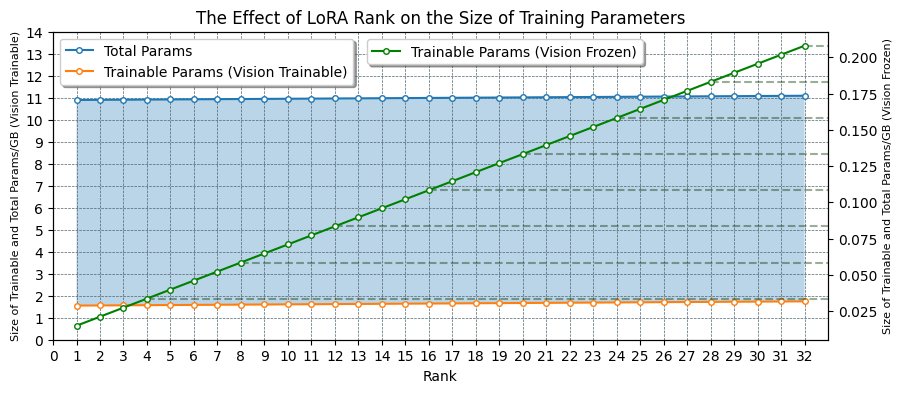

In [5]:
fig, ax1 = plt.subplots(figsize=[10,4])
ax1.plot(rank_list[1:], table[1:,0],marker = "o", mfc = "white", ms = 4)
ax1.plot(rank_list[1:], table[1:,2],marker = "o", mfc = "white", ms = 4)
plt.xlabel('Rank')
ax1.set_ylabel('Size of Trainable and Total Params/GB (Vision Trainable)',fontsize=8)
ax1.set_xticks(rank_list[1:])

ax1.grid(ls = "--", lw = 0.5, color = "#4E616C")
ax1.fill_between(rank_list[1:], table[1:,0], table[1:,2], alpha = 0.3)
ax1.set_yticks(list(range(0, 15)))
ax1.set_xticks(rank_list)
ax2 = ax1.twinx()
for i in range(1,33):
    if not i%4:
        ax2.plot([i,33],[table[i,1],table[i,1]],alpha=0.4,linestyle='--',color=(0,0.2,0))
p1 = ax2.plot(rank_list[1:], table[1:,1],color='green',linestyle='-',marker = "o", mfc = "white", ms = 4)
ax2.set_ylabel('Size of Trainable and Total Params/GB (Vision Frozen)',fontsize=8)
ax1.legend(['Total Params','Trainable Params (Vision Trainable)'],loc='upper left',shadow=True)
ax2.legend(p1,['Trainable Params (Vision Frozen)'],loc=(0.405,0.895),shadow=True)
ax1.set_xlim(0,33)
plt.title('The Effect of LoRA Rank on the Size of Training Parameters')
plt.show()

In [2]:
# 展示量化对节省训练显存和加快训练速度的作用。对比模型效果与量化位数的关系
table = []
def get_totalSize_trainableSize(model):
    total_params_bits = 0
    trainable_params_bits = 0
    for p in model.parameters():
        total_params_bits += p.numel() * p.element_size()
        if p.requires_grad:
            trainable_params_bits += p.numel() * p.element_size()
    return [round(total_params_bits/1024**3, 5), round(trainable_params_bits/1024**3, 5)]


rank = 16
bit_list = [4, 32]
for bit in bit_list:
    model, tokenizer = load_hf_model(model_path, bit=bit, lora=True, lora_rank=rank, freeze_vision=1)
    model = model.eval()
    tu = get_totalSize_trainableSize(model)

    model, tokenizer = load_hf_model(model_path, bit=bit, lora=True, lora_rank=rank, freeze_vision=0)
    model = model.eval()
    tu.append(get_totalSize_trainableSize(model)[1])
    table.append(tu)
    print(f'Bit{bit}\tRank{rank}\t Total params:{tu[0]}GB\t Trainable params(frozen vision):{tu[1]}GB\tTrainable params(Enable vision):{tu[2]}GB')

table = np.array(table)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

D:\Anaconda\envs\He\lib\site-packages\peft\tuners\tuners_utils.py:550: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['model.embed_tokens', 'lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Bit4	Rank16	 Total params:3.18018GB	 Trainable params(frozen vision):0.09957GB	Trainable params(Enable vision):0.10162GB


D:\Anaconda\envs\He\lib\site-packages\accelerate\utils\modeling.py:1569: UserWarning: Current model requires 9216 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Bit32	Rank16	 Total params:10.99033GB	 Trainable params(frozen vision):0.10837GB	Trainable params(Enable vision):1.64484GB


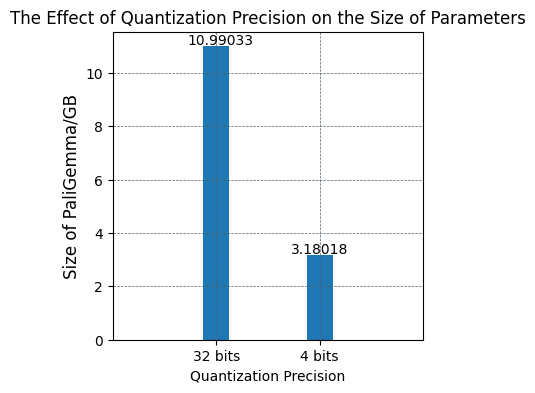

In [49]:
table = np.array([[10.99033,0.10837,1.64484],[3.18018, 0.09957, 0.10162]])
plt.figure(figsize=[4,4])
plt.bar([0,2], table[:,0],width = 0.5)
plt.xlabel('Quantization Precision')
plt.ylabel('Size of PaliGemma/GB',fontsize=12)
plt.xlim(-2,4)
plt.xticks([0,2],['32 bits','4 bits'])

plt.text(-0.55,table[0,0]+0.07,str(table[0,0]))
plt.text(1.45,table[1,0]+0.07,str(table[1,0]))
plt.grid(ls = "--", lw = 0.5, color = "#4E616C")
plt.title('The Effect of Quantization Precision on the Size of Parameters')
plt.show()

In [37]:
str(table[0,0])

'10.99033'

In [3]:
model.multi_modal_projector.linear

Linear(in_features=1152, out_features=2048, bias=True)